In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
from Utils.DataLoader import DataLoader
from Utils.DataTransformer import DataTransformer
from Utils.DuckDb.DuckDb import DuckDb
from Utils.DatasetProcessor.DatasetProcessorUtils import DatasetProcessorUtils
from Utils.DataAnalysis import DataAnalysis
from datetime import datetime
import pandas as pd
from typing import List
from Utils import PandasNotebookConfigs
import project_config
import numpy as np
import matplotlib.pyplot as plt
import joblib
from datetime import datetime
from Utils.Datetime import DatetimeUtils
from Utils.Dict import DictUtils
from Utils.Number import NumberUtils

In [103]:
PandasNotebookConfigs.config()

Ajustando display.float.format para %.4f


In [104]:
DUCK_DB = DuckDb()
DATA_TRANSFORMER = DataTransformer()
DATA_PROCESSOR_UTILS = DatasetProcessorUtils(DUCK_DB)
DATETIME_UTILS = DatetimeUtils()
DICT_UTILS = DictUtils()
DATA_ANALYSIS = DataAnalysis()
NUMBER_UTILS = NumberUtils()

In [105]:
df = DUCK_DB.load_table(
    project_config.PREDICTED_DATA_TABLE
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [106]:
len(df)

1251070

In [107]:
# Get only churn labeled data to check why our model isn't predicting well
df = df[df['no_churn_information'] == False]

In [108]:
len(df)

660119

In [109]:
df.head()[['is_churn', 'predicted_is_churn', 'predicted_is_churn_proba_false', 'predicted_is_churn_proba_true']]

,is_churn,predicted_is_churn,predicted_is_churn_proba_false,predicted_is_churn_proba_true
0,True,True,0.1445,0.8555
1,False,True,0.3927,0.6073
5,False,True,0.4260,0.5740
6,False,False,0.5529,0.4471
7,True,True,0.2045,0.7955


In [110]:
def create_is_bad_prediction_column(df: pd.DataFrame) -> pd.DataFrame:
    def process(row: pd.Series):
        biggest_proba = max(
            row['predicted_is_churn_proba_false'],
            row['predicted_is_churn_proba_true']
        )
        return biggest_proba < 0.65
    
    df['is_bad_prediction'] = df.apply(lambda row: process(row), axis=1)
    return df

df = create_is_bad_prediction_column(df)
df.head()

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,...,registered_via_16,registered_via_17,registered_via_18,registered_via_19,safra_year,safra_month,predicted_is_churn,predicted_is_churn_proba_false,predicted_is_churn_proba_true,is_bad_prediction
0,55.9125,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,60,12,14,7,171,179,49996,...,False,False,False,False,2016.0000,9.0000,True,0.1445,0.8555,False
1,67.3556,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,128,71,50,101,470,488,148668,...,False,False,False,False,2016.0000,11.0000,True,0.3927,0.6073,True
5,70.9467,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201609,53,28,18,19,665,707,173410,...,False,False,False,False,2016.0000,9.0000,True,0.4260,0.5740,True
6,73.1067,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201610,32,12,14,20,755,791,190726,...,False,False,False,False,2016.0000,10.0000,False,0.5529,0.4471,True
7,66.1132,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201611,59,23,11,21,520,545,133337,...,False,False,False,False,2016.0000,11.0000,True,0.2045,0.7955,False


In [111]:
def create_correct_prediction_column(df: pd.DataFrame) -> pd.DataFrame:    
    df['correct_prediction'] = df['is_churn'] == df['predicted_is_churn']
    return df

df = create_correct_prediction_column(df)
df.head(10)[['is_churn', 'predicted_is_churn', 'correct_prediction']]

,is_churn,predicted_is_churn,correct_prediction
0,True,True,True
1,False,True,False
5,False,True,False
6,False,False,True
7,True,True,True
10,False,False,True
11,False,False,True
12,False,False,True
16,False,True,False
17,False,True,False


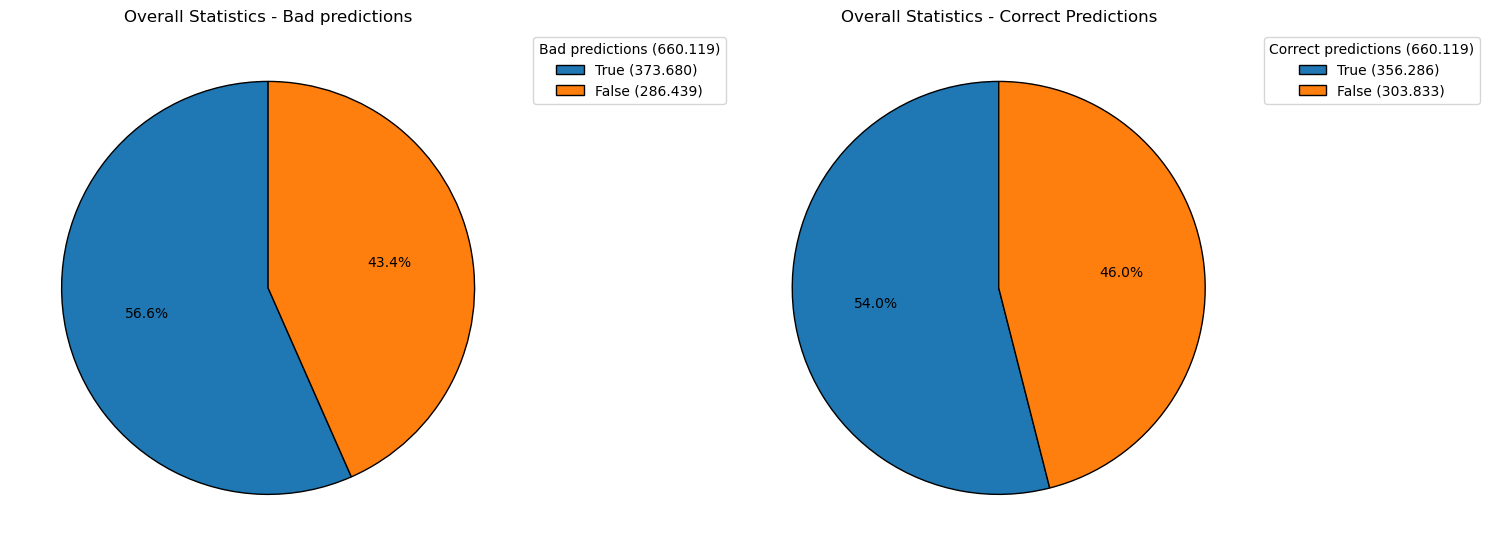

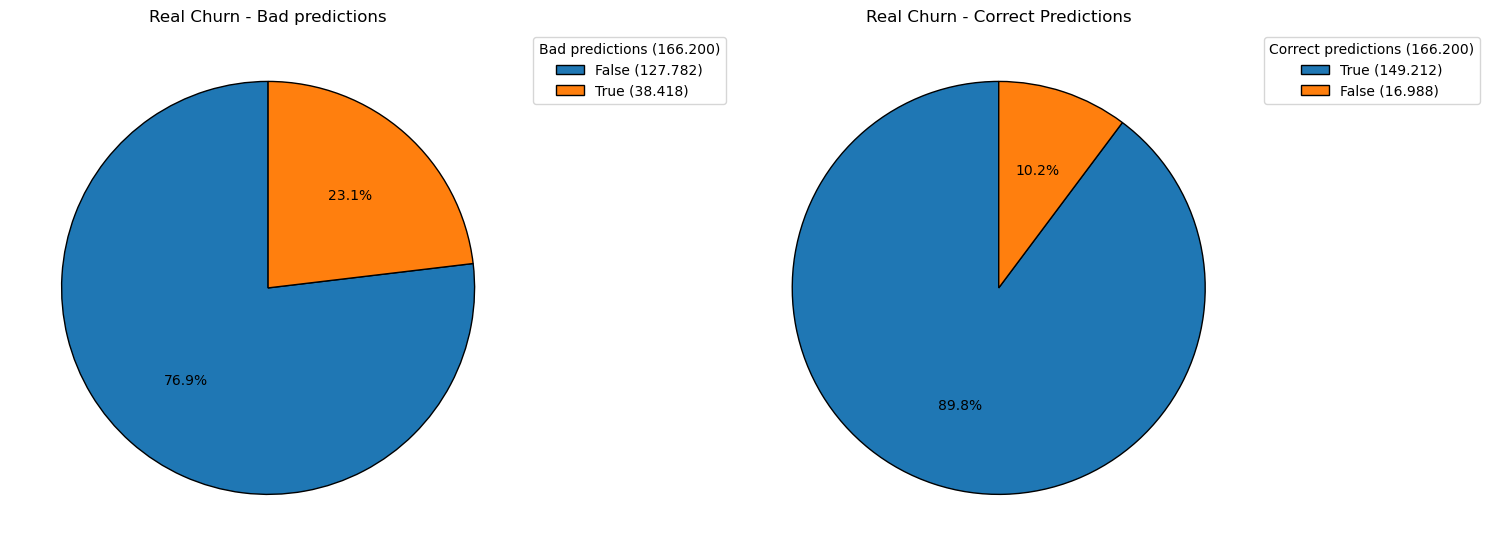

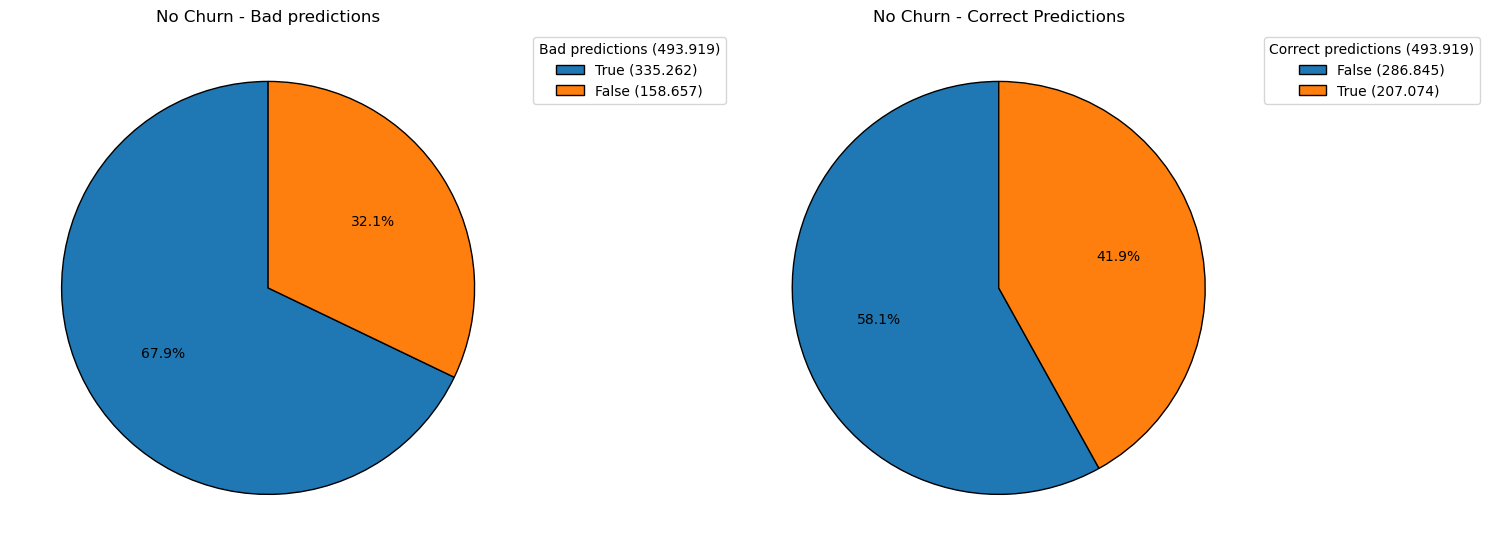

In [114]:
def plot_figures(label: str, df: pd.DataFrame):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
    axes = axes.flatten()

    def generate_labels(counts):
        return [f'{c} ({NUMBER_UTILS.format_integer_number(counts[c])})' for c in counts.index]

    counted = df['is_bad_prediction'].value_counts()
    labels = generate_labels(counted)
    DATA_ANALYSIS.plot_pizza(
        value_counts=counted,
        labels=labels,
        title=f'{label} - Bad predictions',
        legend=f'Bad predictions ({NUMBER_UTILS.format_integer_number(counted.sum())})',
        ax=axes[0]
    )

    counted = df['correct_prediction'].value_counts()
    labels = generate_labels(counted)
    DATA_ANALYSIS.plot_pizza(
        value_counts=counted,
        labels=labels,
        title=f'{label} - Correct Predictions',
        legend=f'Correct predictions ({NUMBER_UTILS.format_integer_number(counted.sum())})',
        ax=axes[1]
    )

    plt.tight_layout()
    plt.show()

plot_figures(
    label='Overall Statistics',
    df=df
)

plot_figures(
    label='Real Churn',
    df=df[df['is_churn'] == True]
)

plot_figures(
    label='No Churn',
    df=df[df['is_churn'] == False]
)

In [99]:
df[df['is_churn'] == True]

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,...,registered_via_17,registered_via_18,registered_via_19,safra_year,safra_month,predicted_is_churn,predicted_is_churn_proba_false,predicted_is_churn_proba_true,is_bad_prediction,correct_prediction
0,55.9125,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,60,12,14,7,171,179,49996,...,False,False,False,2016.0000,9.0000,True,0.1445,0.8555,False,True
1,67.3556,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,128,71,50,101,470,488,148668,...,False,False,False,2016.0000,11.0000,True,0.3927,0.6073,True,True
5,70.9467,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201609,53,28,18,19,665,707,173410,...,False,False,False,2016.0000,9.0000,True,0.4260,0.5740,True,True
7,66.1132,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201611,59,23,11,21,520,545,133337,...,False,False,False,2016.0000,11.0000,True,0.2045,0.7955,False,True
16,73.3626,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,201609,198,79,58,65,680,571,204505,...,False,False,False,2016.0000,9.0000,True,0.4509,0.5491,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251049,71.3801,GM+zohTzoOBKEhzwBoGIRCoNMOS7+O4b/psRR8MfBKw=,201610,149,133,37,39,632,324,197277,...,False,False,False,2016.0000,10.0000,True,0.1866,0.8134,False,True
1251050,75.5710,GM+zohTzoOBKEhzwBoGIRCoNMOS7+O4b/psRR8MfBKw=,201611,132,158,25,25,704,789,215471,...,False,False,False,2016.0000,11.0000,True,0.2294,0.7706,False,True
1251053,91.6732,GM//NhdY68bzfkGv+FiiP9CdwP+Gbzw8Wtz09ZnGETs=,201609,35,15,14,10,1451,731,379451,...,False,False,False,2016.0000,9.0000,True,0.4567,0.5433,True,True
1251054,107.2552,GM//NhdY68bzfkGv+FiiP9CdwP+Gbzw8Wtz09ZnGETs=,201611,327,45,30,31,1915,1676,487076,...,False,False,False,2016.0000,11.0000,True,0.4513,0.5487,True,True


In [11]:
# Group by msno and get the last register
df = df.groupby('msno').tail(1)
len(df)

262270

In [12]:
df = df[project_config.COLUMNS_USED_ON_TRAIN_AND_PREDICTION + [project_config.TARGET_COLUMN]]

In [13]:
df.head()

,registration_init_time_day,registration_init_time_day_of_year,registration_init_time_year,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,transaction_date_month,membership_expire_date_day,membership_expire_date_day_of_year,membership_expire_date_month,...,payment_method_id_39,payment_method_id_4,payment_method_id_40,payment_method_id_41,payment_method_id_5,payment_method_id_6,payment_method_id_7,payment_method_id_8,payment_method_id_9,is_churn
3,8,159,2014,15,2,46,2,15,74,3,...,False,False,False,True,False,False,False,False,False,False
6,18,322,2010,31,1,31,1,19,78,3,...,True,False,False,False,False,False,False,False,False,False
10,27,270,2014,26,6,57,2,26,85,3,...,False,False,False,True,False,False,False,False,False,False
14,15,75,2016,15,2,46,2,15,74,3,...,False,False,False,True,False,False,False,False,False,False
17,22,22,2012,31,1,31,1,23,82,3,...,True,False,False,False,False,False,False,False,False,False


In [14]:
# test_df = df[:10_000].copy()
test_df = df.copy()

In [15]:
usage_df = test_df[USAGE_COLUMNS]

In [16]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=len(CLUSTERS), random_state=42)
customer_clusters = kmeans.fit_predict(usage_df)

In [17]:
# Assign cluster labels to the DataFrame
usage_df['cluster'] = kmeans.labels_

# View centroids (cluster centers)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=usage_df.columns[:-1])  # Exclude the cluster column
print("Cluster Centroids:")
print(centroids)

Cluster Centroids:
    num_100  num_100-1M  num_100-2M   num_25  num_25-1M  num_25-2M  num_50  \
0 1080.1894   1188.1396   1176.2384 185.1650   214.7626   220.0776 44.8861   
1  205.6065    232.4345    231.8507  63.3218    72.6760    74.1828 15.3135   

   num_50-1M  num_50-2M  num_75  ...  num_985  num_985-1M  num_985-2M  \
0    50.9948    52.3299 29.6592  ...  34.6928     38.9614     39.1098   
1    17.3908    17.8744  9.3750  ...  10.0439     11.5293     11.5135   

   num_unq  num_unq-1M  num_unq-2M  total_secs  total_secs-1M  total_secs-2M  \
0 975.6573   1085.3174   1083.2445 280467.4606    309555.7020    307313.7790   
1 232.6934    264.6449    266.1760  55447.1650     62877.5830     62944.9960   

   is_churn  
0    0.0387  
1    0.1313  

[2 rows x 22 columns]


/tmp/ipykernel_782/2243360524.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usage_df['cluster'] = kmeans.labels_


In [18]:
import numpy as np

# Compute the standard deviation of each feature across clusters
feature_importance = centroids.std(axis=0).sort_values(ascending=False)

# Get the top 10 features
top_10_features = feature_importance.head(10)
print("Top 10 Features Differentiating the Clusters:")
print(top_10_features)


Top 10 Features Differentiating the Clusters:
total_secs-1M   174427.7707
total_secs-2M   172794.8235
total_secs      159113.3769
num_100-1M         675.7856
num_100-2M         667.7829
num_100            618.4235
num_unq-1M         580.3030
num_unq-2M         577.7546
num_unq            525.3548
num_25-2M          103.1632
dtype: float64


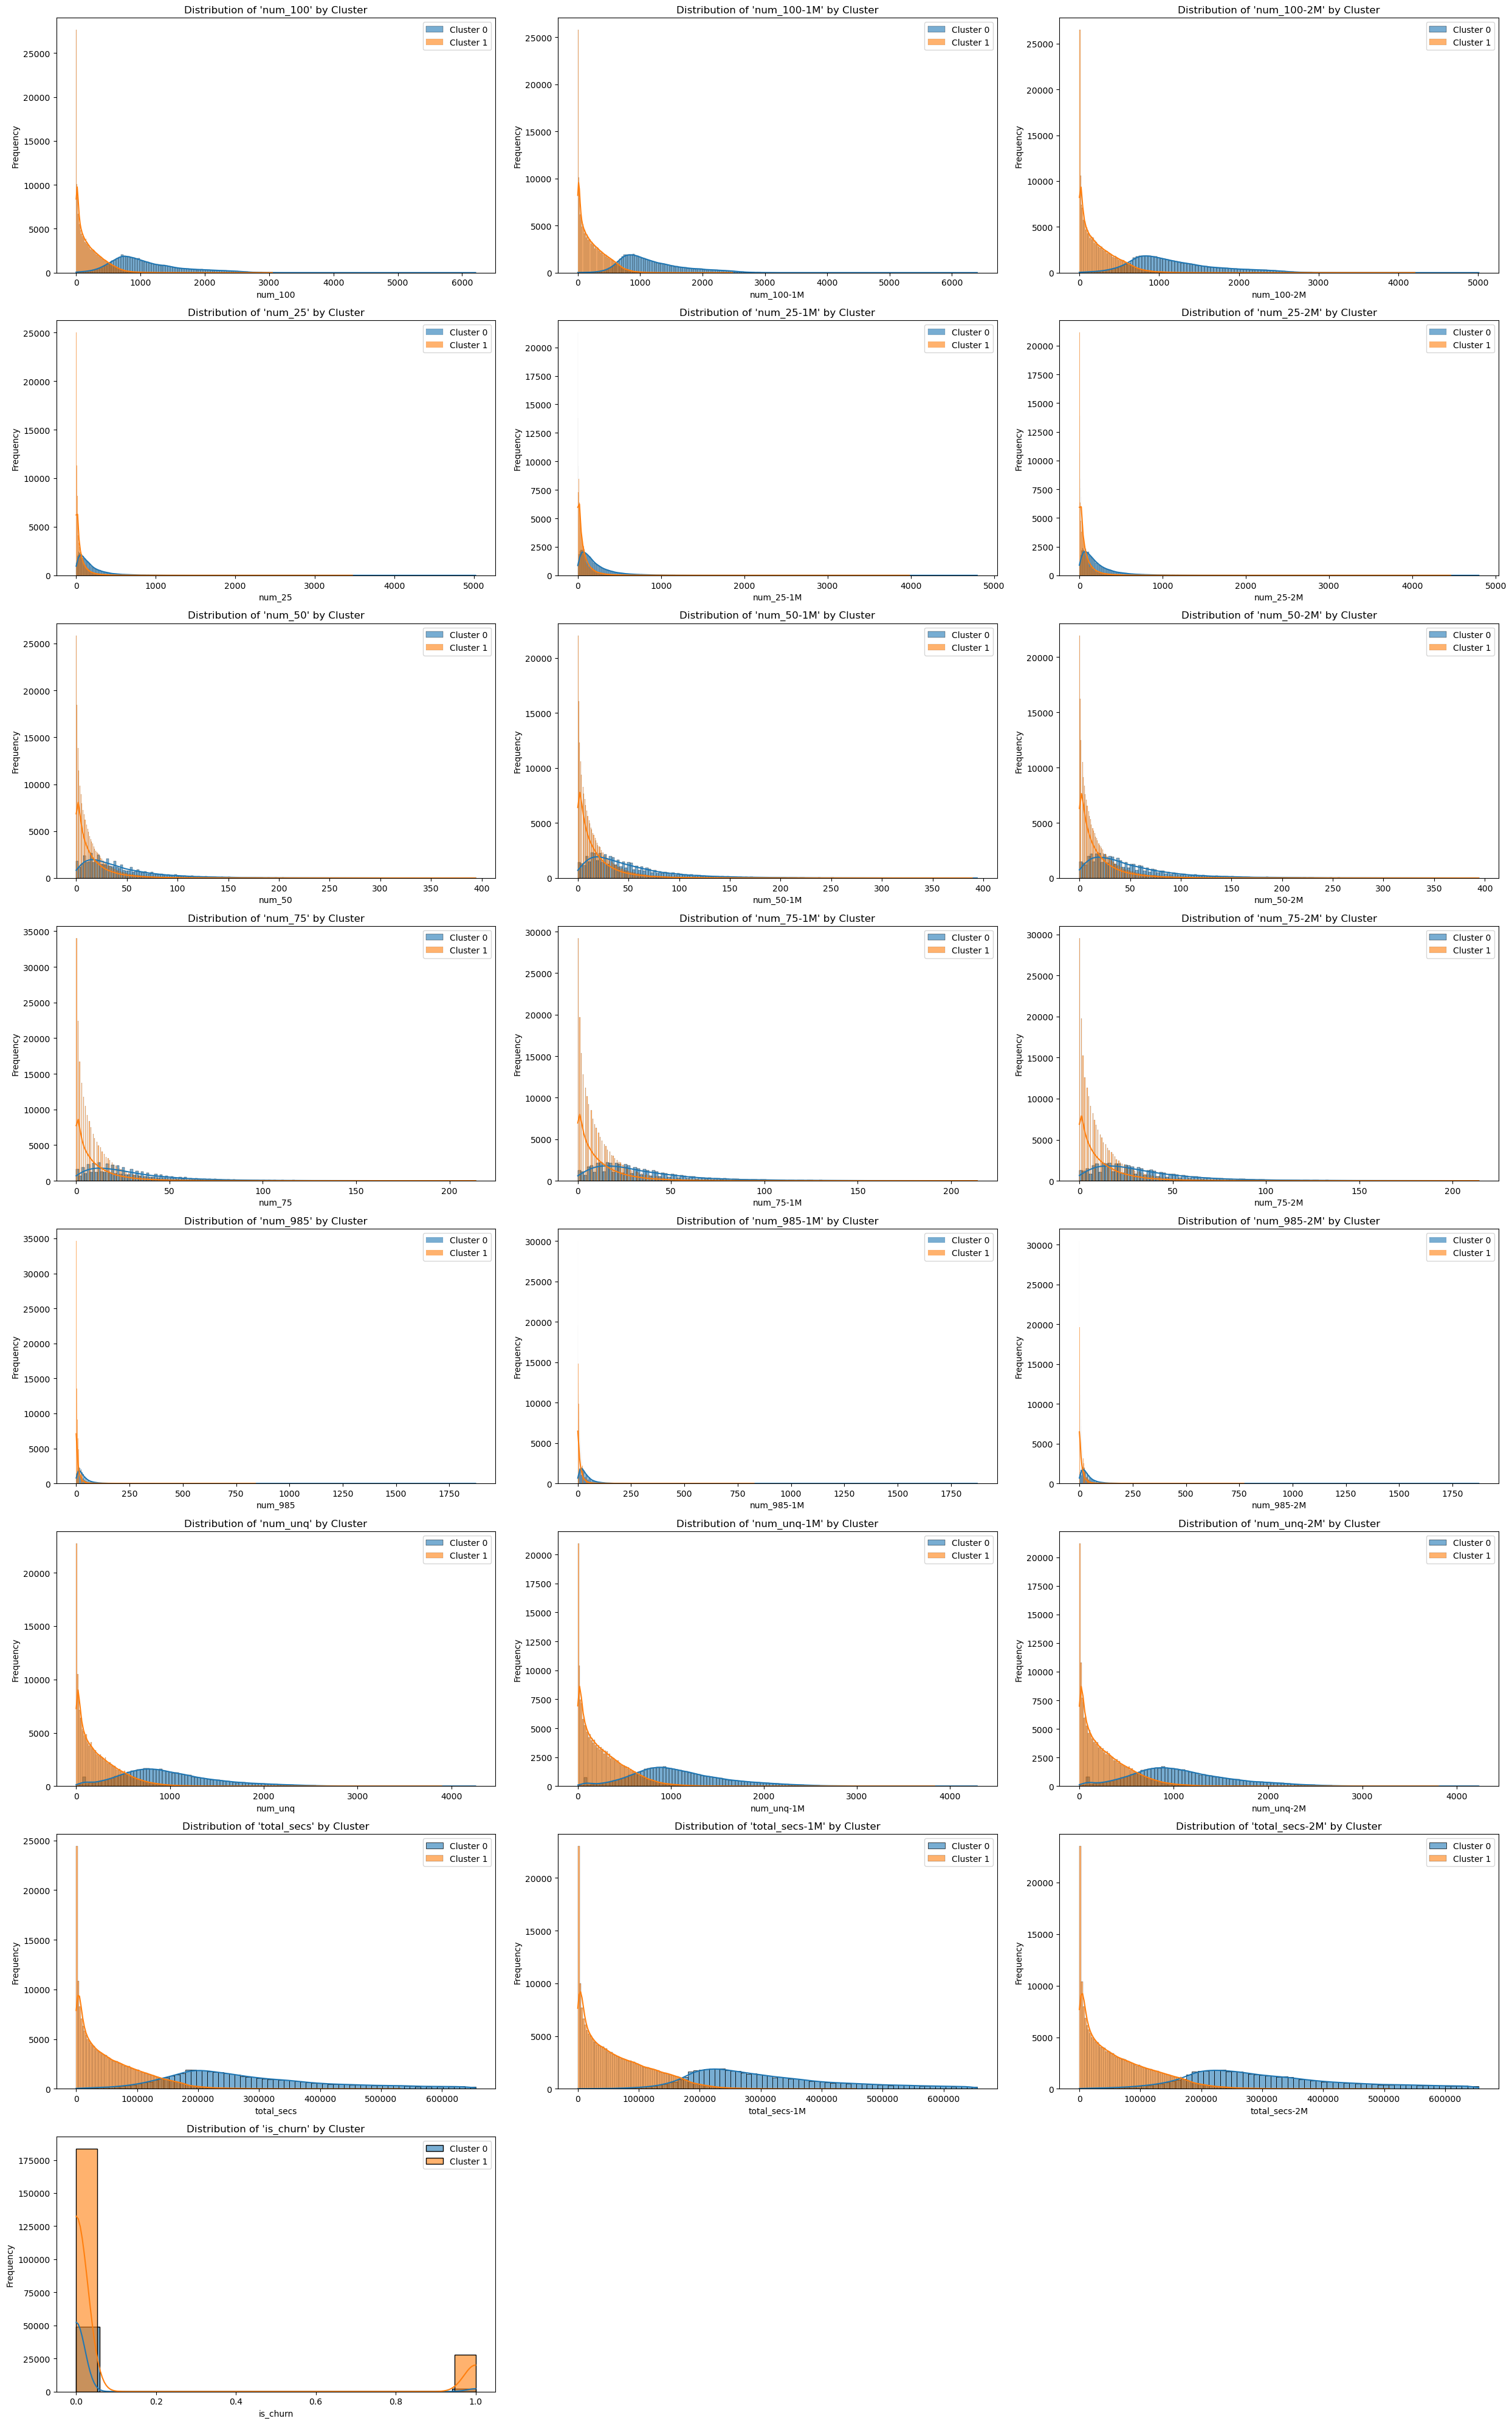

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Extract features (excluding 'cluster') and define the number of rows/columns
features = usage_df.drop('cluster', axis=1).columns
n_features = len(features)
n_cols = 3  # Number of figures per row
n_rows = math.ceil(n_features / n_cols)  # Calculate the number of rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, n_rows * 5))  # Adjust the figure size
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Iterate through each feature and create a histogram
for i, feature in enumerate(features):
    ax = axes[i]
    for cluster_id in usage_df['cluster'].unique():
        sns.histplot(
            data=usage_df[usage_df['cluster'] == cluster_id],
            x=feature,
            kde=True,
            label=f'Cluster {cluster_id}',
            alpha=0.6,
            ax=ax  # Specify the subplot for this feature
        )
    ax.set_title(f"Distribution of '{feature}' by Cluster")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")
    ax.legend()

# Hide unused subplots if the number of features is not a multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [20]:
from typing import Dict


def get_cluster_value_map(df: pd.DataFrame) -> Dict[str, any]:
    field_to_consider = 'total_secs'

    # Order clusters by total_secs mean value
    cluster_mean_total_secs = {}
    for i in range(0, len(CLUSTERS)):
        cluster_df = df[df['cluster'] == i]
        cluster_mean_total_secs[i] = cluster_df[field_to_consider].mean()

    cluster_mean_total_secs = DICT_UTILS.sort_dict_by_values(cluster_mean_total_secs)

    cluster_names = {}
    sorted_clusters_keys = list(cluster_mean_total_secs.keys())
    sorted_clusters_keys.reverse()
    for index, key in enumerate(sorted_clusters_keys):
        # print(f'Cluster {key} = {CLUSTERS[index]}')
        cluster_names[key] = CLUSTERS[index]

    return cluster_names

In [21]:
# Giving names to clusters
def name_clusters(df: pd.DataFrame) -> pd.DataFrame:
    cluster_names = get_cluster_value_map(df)

    # Filling out the cluster_named column
    col_data = []
    for _, row in usage_df.iterrows():
        row_cluster = row['cluster']

        col_data.append(cluster_names[row_cluster])

    df['cluster_named'] = col_data
    return df

In [22]:
usage_df = name_clusters(usage_df)

/tmp/ipykernel_782/3569267362.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_named'] = col_data


In [23]:
usage_df.head(20)

,num_100,num_100-1M,num_100-2M,num_25,num_25-1M,num_25-2M,num_50,num_50-1M,num_50-2M,num_75,...,num_985-2M,num_unq,num_unq-1M,num_unq-2M,total_secs,total_secs-1M,total_secs-2M,is_churn,cluster,cluster_named
3,468,438.0000,855.0000,116,135.0000,193.0000,61,69.0000,88.0000,58,...,142.0000,642,696.0000,979.0000,156533,157868.0000,256812.0000,False,0,Heavy User
6,715,533.0000,520.0000,108,43.0000,59.0000,36,25.0000,23.0000,30,...,21.0000,840,676.0000,545.0000,198105,154978.0000,133337.0000,False,1,Light User
10,383,651.0000,579.0000,188,289.0000,166.0000,80,175.0000,73.0000,46,...,43.0000,551,1088.0000,645.0000,123768,215757.0000,169086.0000,False,1,Light User
14,258,384.0000,483.0000,103,54.0000,86.0000,47,9.0000,24.0000,27,...,23.0000,194,130.0000,342.0000,78863,106043.0000,132765.0000,False,1,Light User
17,176,190.0000,91.0000,88,58.0000,49.0000,19,24.0000,11.0000,14,...,18.0000,304,270.0000,165.0000,51758,54255.0000,29430.0000,False,1,Light User
19,183,183.0000,183.0000,14,14.0000,14.0000,1,1.0000,1.0000,5,...,0.0000,140,140.0000,140.0000,43731,43731.0000,43731.0000,False,1,Light User
23,22,87.0000,94.0000,4,9.0000,82.0000,4,7.0000,44.0000,4,...,21.0000,28,95.0000,207.0000,5712,22640.0000,33137.0000,False,1,Light User
24,24,24.0000,24.0000,6,6.0000,6.0000,1,1.0000,1.0000,1,...,0.0000,20,20.0000,20.0000,6352,6352.0000,6352.0000,True,1,Light User
26,86,86.0000,86.0000,21,21.0000,21.0000,8,8.0000,8.0000,1,...,2.0000,115,115.0000,115.0000,23387,23387.0000,23387.0000,False,1,Light User
27,1,1.0000,1.0000,0,0.0000,0.0000,0,0.0000,0.0000,0,...,0.0000,1,1.0000,1.0000,392,392.0000,392.0000,True,1,Light User


In [24]:
def get_usage_info_form_clusters(df: pd.DataFrame):
    cols = [
        'total_secs',
        'num_unq'
    ]

    cluster_values_map = get_cluster_value_map(df)

    for cluster in cluster_values_map:
        grp = df[df['cluster'] == cluster]
        print(f'Cluster {cluster_values_map[cluster]}')

        for col in cols:
            print(f'\t-> Mediana de {col}: {grp[col].median()}')
            # print(f'\t-> Média de {col}: {grp[col].mean()}')
            # print()

        print()
        # print(grp)


get_usage_info_form_clusters(usage_df)

Cluster Heavy User
	-> Mediana de total_secs: 251031.0
	-> Mediana de num_unq: 897.0

Cluster Light User
	-> Mediana de total_secs: 39541.0
	-> Mediana de num_unq: 163.0



In [25]:
from typing import List


def plot_pizza(
    value_counts: pd.DataFrame, labels: List[str], title: str, legend: str, ax: plt = None,
    colors: List[str] = None
):
    if ax is None:
        fig, ax = plt.subplots()

    ax.pie(
        value_counts,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor': 'black'},
        colors=colors,
        # frame=ax,
        # textprops={'color': 'white'}
    )

    ax.set_title(title)

    ax.legend(
        labels,
        title=legend,
        bbox_to_anchor=(1.0, 1),
    )

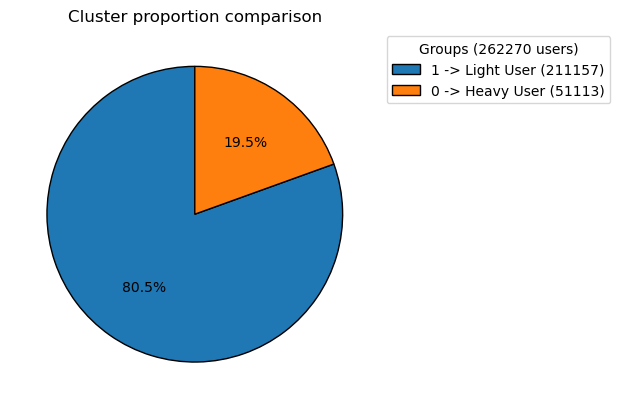

In [26]:
def compare_cluster_proportion(df: pd.DataFrame):
    cluster_value_map = get_cluster_value_map(df)

    counted = df['cluster'].value_counts()
    labels = []
    for i in counted.index:
        labels.append(
            f'{i} -> {cluster_value_map[i]} ({counted[i]})'
        )

    plot_pizza(
        value_counts=counted,
        labels=labels,
        title='Cluster proportion comparison',
        legend=f'Groups ({len(df)} users)'
    )

compare_cluster_proportion(usage_df)

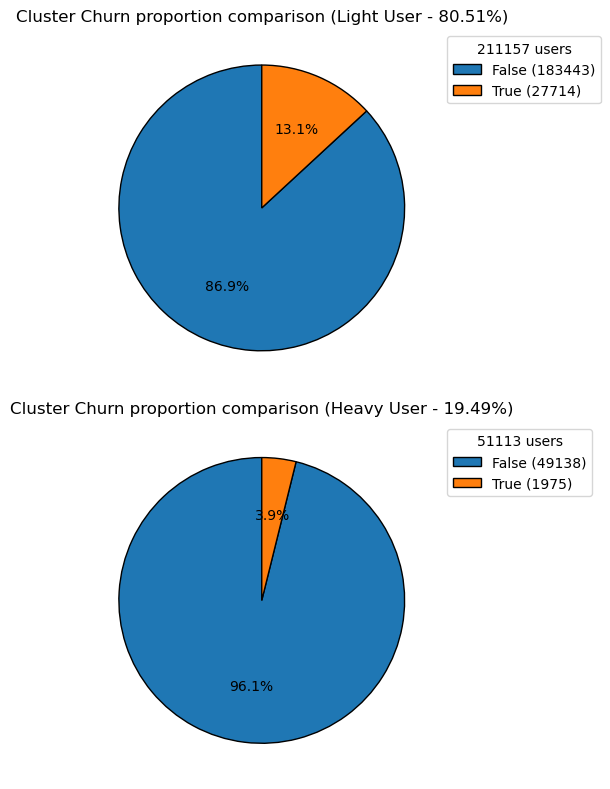

In [27]:
def compare_cluster_is_churn_proportion(df: pd.DataFrame):
    cluster_value_map = get_cluster_value_map(df)

    n_rows = len(CLUSTERS)
    n_cols = 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 8))  # Adjust the figure size
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    cluster_counted = df['cluster'].value_counts()
    for index, cluster in enumerate(cluster_counted.index):
        filtered_df =  df[df['cluster'] == cluster]
        is_churn_counted = filtered_df['is_churn'].value_counts()

        cluster_percentage = len(filtered_df) * 100 / len(df)

        plot_pizza(
            value_counts=is_churn_counted,
            labels=[f'{x} ({is_churn_counted[x]})' for x in is_churn_counted.index],
            title=f'Cluster Churn proportion comparison ({cluster_value_map[cluster]} - {cluster_percentage:.2f}%)',
            legend=f'{len(filtered_df)} users',
            ax=axes[index],
        )

    plt.tight_layout()
    plt.show()

compare_cluster_is_churn_proportion(usage_df)

# Conclusão
Podemos perceber 3 tipos de usuários:
- Usuários Casuais (usam menos a plataforma; são a grande maioria)
- Usuários Pesados (utilizam de forma intensa)

Quanto mais os usuários utilizam a plataforma, menos eles tendem a virar churn no futuro.

## Store this code

In [ ]:
# Utilizando o método da Silhueta, pois ele foca na qualidade dos agrupamentos
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

X = usage_df.copy()[USAGE_COLUMNS]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

range_n_clusters = list(range(2, 11))
silhouette_avg = []

for n_clusters in range_n_clusters:
    print(f'')
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg.append(silhouette_score(X_scaled, cluster_labels))

plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.title("Análise da Silhueta")
plt.xlabel("Número de Clusters")
plt.ylabel("Média do Índice de Silhueta")
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

optimal_n_clusters = range_n_clusters[silhouette_avg.index(max(silhouette_avg))]
print(f"O número ideal de clusters é {optimal_n_clusters} com índice de silhueta médio de {max(silhouette_avg):.2f}")
